# GCA-ROM

This notebook trains the GCA-ROM model (link) and evaluates the performance.

In [1]:
import torch
import torch_geometric
import numpy as np
from itertools import product
import time
from torchinfo import summary

import sys
sys.path.append('../../gca-rom')
from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui

sys.path.append('..')
from gfn_rom import defaults

In [2]:
problem_name, variable, mu_space, n_param, dim_pde, n_comp = pde.problem(10)
argv = ['stokes_u', 'U', 4, 3, 1, defaults.rate, 200, defaults.mapper_sizes[0], int(n_param*defaults.N_basis_factor), defaults.mapper_weight, 2, n_param, defaults.epochs, n_comp]
HyperParams = network.HyperParams(argv)

HyperParams.learning_rate = defaults.lr
HyperParams.weight_decay = defaults.lambda_
HyperParams.seed = defaults.split_seed

# load data in batches
# If memory issues, reduce batch size
HyperParams.batch_size = np.inf

# remove early stopping and scheduler
HyperParams.tolerance = 0
HyperParams.miles = []
HyperParams.gamma = 1

In [3]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cuda


In [4]:
dataset_dir = 'data/matrix_large.mat'
dataset = loader.LoadDataset(dataset_dir, variable, dim_pde, n_comp)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

Number of nodes processed:  7019
Number of graphs processed:  704
Length of train dataset:  211
Length of test dataset:  493


In [5]:
HyperParams.seed = defaults.seed
initialization.set_reproducibility(HyperParams)

model = network.Net(HyperParams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

In [6]:
summary(model)

Layer (type:depth-idx)                        Param #
Net                                           --
├─Encoder: 1-1                                --
│    └─ModuleList: 2-1                        --
│    │    └─GMMConv: 3-1                      17
│    └─Linear: 2-2                            1,404,000
│    └─Linear: 2-3                            2,010
├─Decoder: 1-2                                --
│    └─Linear: 2-4                            2,200
│    └─Linear: 2-5                            1,410,819
│    └─ModuleList: 2-6                        --
│    │    └─GMMConv: 3-2                      17
├─ModuleList: 1-3                             --
│    └─Linear: 2-7                            400
│    └─Linear: 2-8                            2,550
│    └─Linear: 2-9                            2,550
│    └─Linear: 2-10                           2,550
│    └─Linear: 2-11                           510
Total params: 2,827,623
Trainable params: 2,827,623
Non-trainable params: 0

In [7]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt'))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    start = time.time()
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)
    end = time.time() - start
    print(f"Time elapsed = ", end)

Loading saved network


In [8]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 704/704 [00:02<00:00, 330.34it/s]


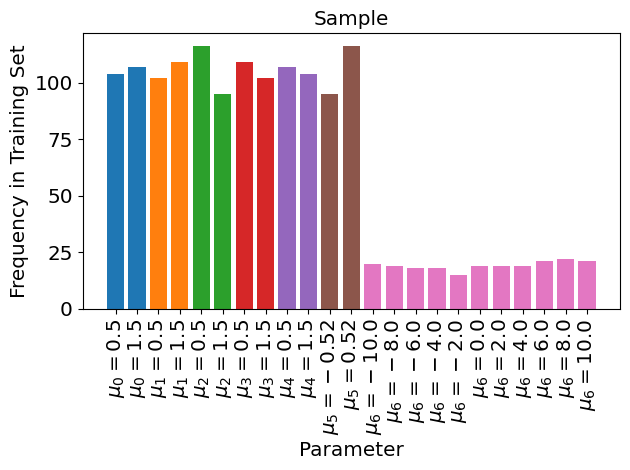

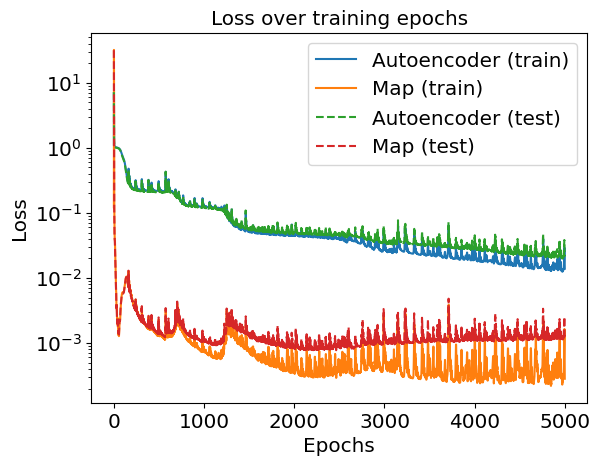

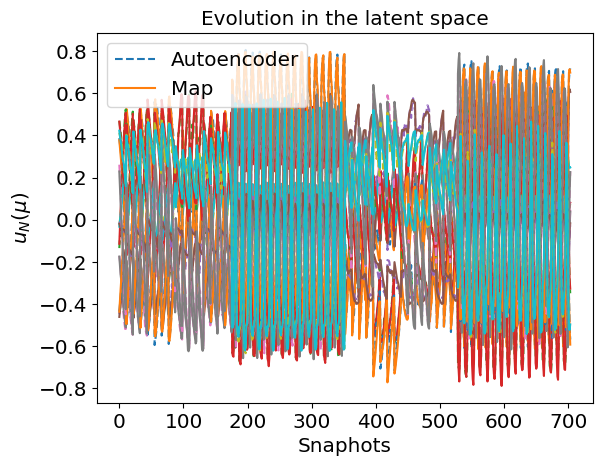

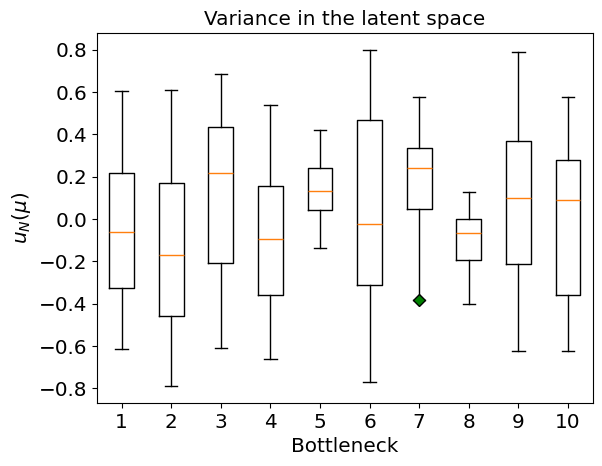

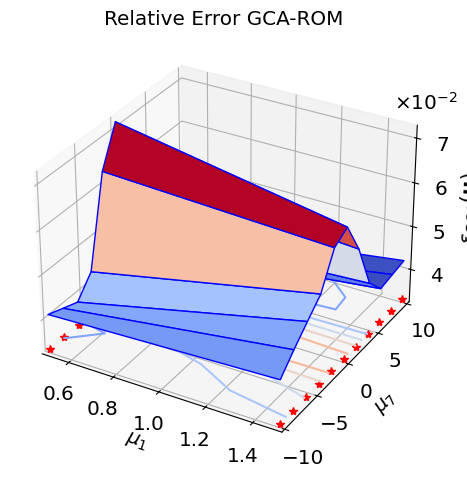

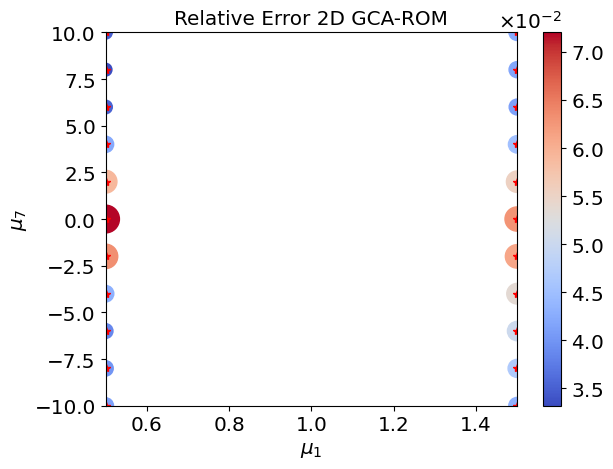

In [9]:
plotting.plot_sample(HyperParams, mu_space, params, train_trajectories, test_trajectories, param_frequency=True)
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)

plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)
plotting.plot_error_2d(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

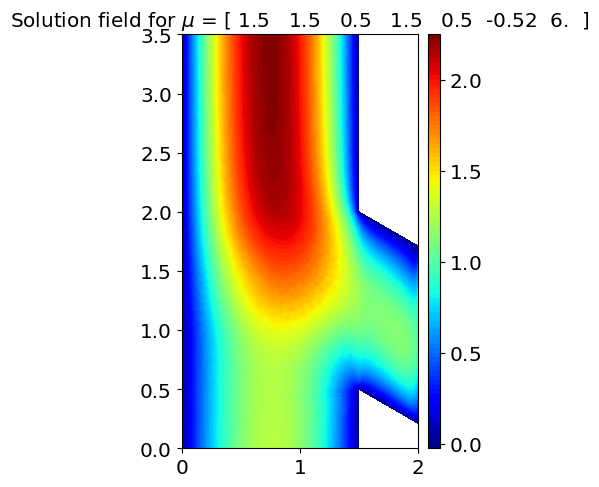

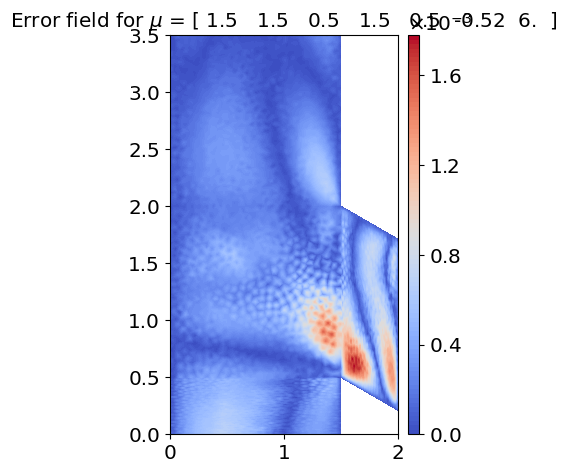

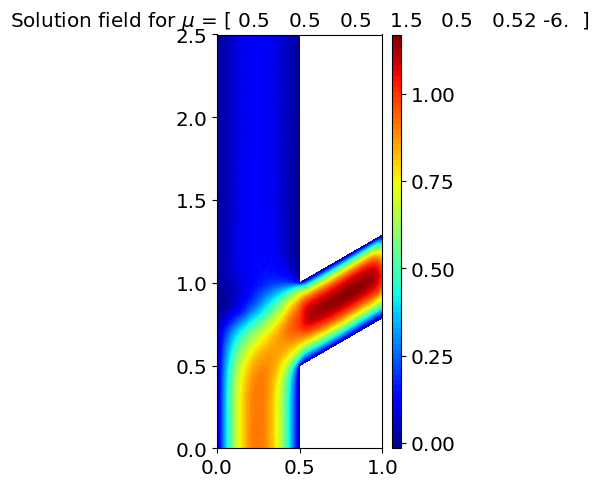

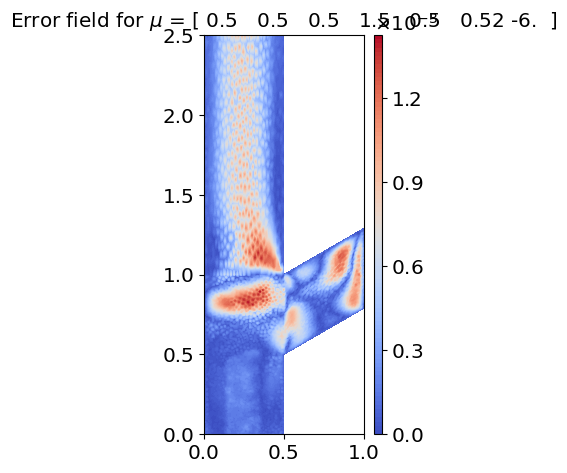

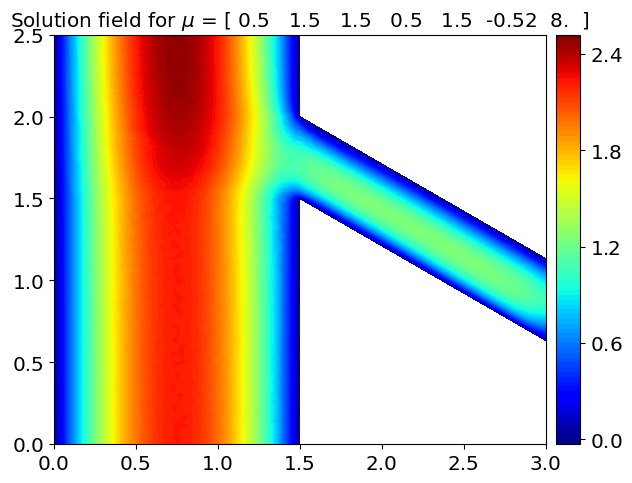

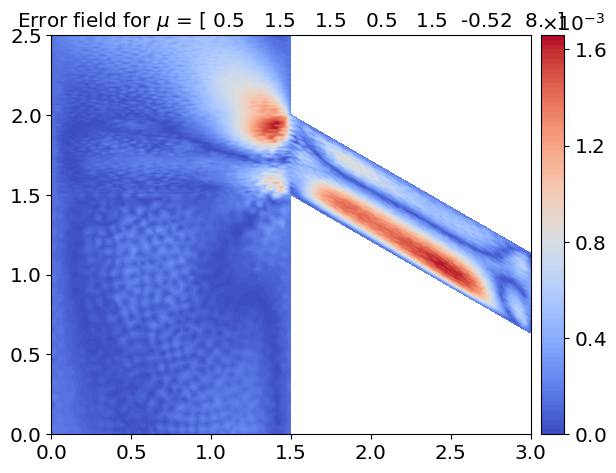

In [10]:
N = 3
snapshots = np.arange(params.shape[0]).tolist()
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)


Maximum absolute error for field GCA-ROM =  11.572595769365513
Mean absolute error for field GCA-ROM =  3.573045073470269
Minimum absolute error for field GCA-ROM =  0.9883684267311607

Maximum relative error for field GCA-ROM =  0.13779130899277192
Mean relative error for field GCA-ROM =  0.04755487510074446
Minimum relative error for field GCA-ROM =  0.017463548620920005


<Figure size 640x480 with 0 Axes>

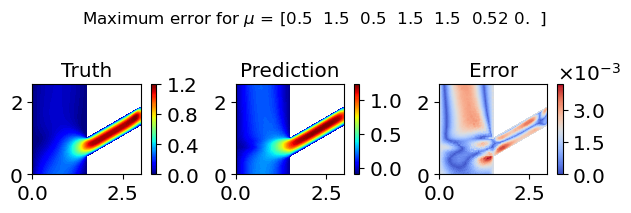

In [11]:
# results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

error_abs, norm = error.compute_error(results, VAR_all, scaler_all, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)

plotting.plot_comparison_fields(results, VAR_all, scaler_all, HyperParams, dataset, xyz, params, adjust_title=0.75)